In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
import math
from pathlib import Path
from skimage.util import img_as_float
from skimage import data, color, morphology, img_as_float
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.model_selection import train_test_split as tts
import imageio
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn import datasets, svm, pipeline
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.math import confusion_matrix
import seaborn as sns
import time

In [ ]:
### First create train and test, and put into classes

In [ ]:
IMAGE_DIRECTORY_1 = "C:/Users/isaac\Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/HAM10000_images_part_1"
IMAGE_DIRECTORY_2 = "C:/Users/isaac\Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/HAM10000_images_part_2"
trimmed_data = pd.read_csv("trimmed_dataset.csv",index_col=0)
trimmed_data.head()

In [ ]:
trimmed_data.sort_values(by="lesion_id",axis=0,inplace=True)
# trimmed_data["dx"]=trimmed_data["dx"].map({"bkl":0,"akiec":1,"bcc":2,
#                                            "df":3,"mel":4,"nv":5,"vasc":6})

trimmed_data.drop("lesion_id",axis=1,inplace=True)
trimmed_data.head()

In [ ]:
row_keys = trimmed_data.columns.values
trimmed_data.values

In [ ]:
d = dict(zip(trimmed_data["image_id"],trimmed_data["dx"]))
d

### DO NOT RUN BELOW AGAIN

In [ ]:
train_dir = "C:/Users/isaac/Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/train"
test_dir = "C:/Users/isaac/Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/test"


BATCH_SIZE = 64
IMG_SIZE = (32,32)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                       shuffle=True,
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE)

In [22]:
class_names = train_dataset.class_names

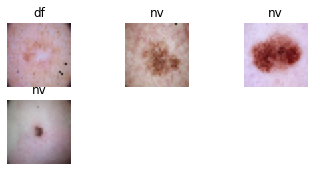

In [23]:
for images, labels in train_dataset.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [24]:
val_batches = tf.data.experimental.cardinality(test_dataset)
validation_dataset = test_dataset.take(val_batches // 5)
test_dataset = test_dataset.skip(val_batches // 5)

In [25]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 6
Number of test batches: 27


In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [27]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [28]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [29]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [30]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = VGG16(input_shape=IMG_SHAPE,
                    include_top=False,
                    weights='imagenet')

In [31]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch[0])

tf.Tensor(
[[[  0.           0.           0.           0.           1.6257373
     0.           0.           0.           0.           2.6607666
     0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.
     0.           0.           0.           0.         232.58696
     0.          45.69107      0.           0.           0.
     0.           0.           0.           0.         141.1767
     0.           0.           0.           0.          60.018147
     0.          39.71767      0.           0.           0.
     0.           0.           0.           0.           0.
     0.           0.           0.           0.          52.633774
     2.513498     0.           0.           0.          17.728489
     0.           0.          38.042927     0.           0.
    59.475945    55.472218     0.           0.          12.261132
     0.           0.           0.         

In [32]:
print(feature_batch.shape)

(64, 1, 1, 512)


In [33]:
base_model.trainable = False

In [34]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 512)


In [35]:
prediction_layer = tf.keras.layers.Dense(7)#,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 7)


In [36]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [37]:
base_learning_rate = 0.0001
callbacks = EarlyStopping(monitor="loss",patience=3,restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 32, 32, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 32, 32, 3)        0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [39]:
len(model.trainable_variables)

2

In [40]:
initial_epochs = 30

loss0, accuracy0 = model.evaluate(validation_dataset)
F
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

6/6 [==============================] - 0s 11ms/step - loss: 14.2767 - accuracy: 0.3125
initial loss: 14.28
initial accuracy: 0.31


In [41]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=test_dataset)

Epoch 1/30
125/125 [==============================] - 3s 21ms/step - loss: 13.2309 - accuracy: 0.3978 - val_loss: 10.3385 - val_accuracy: 0.6046
Epoch 2/30
125/125 [==============================] - 2s 17ms/step - loss: 9.3723 - accuracy: 0.5214 - val_loss: 8.3053 - val_accuracy: 0.6237
Epoch 3/30
125/125 [==============================] - 2s 18ms/step - loss: 7.7512 - accuracy: 0.5480 - val_loss: 7.1275 - val_accuracy: 0.6315
Epoch 4/30
116/125 [==========================>...] - ETA: 0s - loss: 6.9604 - accuracy: 0.5567

KeyboardInterrupt: 

In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [2]:
IMAGE_DIRECTORY_1 = "C:/Users/isaac\Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/HAM10000_images_part_1"
IMAGE_DIRECTORY_2 = "C:/Users/isaac\Documents/Programming/Skin Cancer Analysis and Predictions/dataverse_files/HAM10000_images_part_2"
trimmed_data = pd.read_csv("trimmed_dataset.csv",index_col=0)
trimmed_data.sort_values(by="lesion_id",axis=0,inplace=True)
trimmed_data=pd.get_dummies(trimmed_data,columns=["dx"])
trimmed_data.drop("lesion_id",axis=1,inplace=True)
trimmed_data.set_index("image_id",inplace=True)
row_keys = trimmed_data.columns.values
trimmed_data.head()

,dx_akiec,dx_bcc,dx_bkl,dx_df,dx_mel,dx_nv,dx_vasc
image_id,,,,,,,
ISIC_0028498,0,0,0,0,0,1,0
ISIC_0025346,0,0,0,0,0,1,0
ISIC_0027859,0,0,1,0,0,0,0
ISIC_0032622,0,0,0,0,1,0,0
ISIC_0033848,0,0,0,0,1,0,0


In [3]:
import cv2
from pathlib import Path
from skimage.util import img_as_float

j=0
images = []
image_ids = []
IMG_SIZE= 128
dim = (IMG_SIZE,IMG_SIZE)
dirs = [IMAGE_DIRECTORY_1,IMAGE_DIRECTORY_2]
for directory in dirs:
    for image_name in os.listdir(directory):
        
        filepath = os.path.join(directory,image_name)
#         j+=1

#         if j>2000:
#             break
        new_image = cv2.imread(filepath)
        resized_image = cv2.resize(new_image,dim)
        
        images.append(img_as_float(resized_image))
        image_ids.append(image_name[:-4])

In [4]:
from sklearn.model_selection import train_test_split as tts

X = images
y = trimmed_data.reindex(image_ids).values

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [ ]:
for num_dense in [1,2]:
    for num_conv in [2,3,4]:
        for repeat in range(3):
            
            NAME = "{}-conv-{}-dense-{}-repeat-{}".format(num_conv,num_dense,repeat+1,int(time.time()))
            tensorboard = TensorBoard(log_dir='logs_128x128x3/{}'.format(NAME))#tests
            X_train, X_test, y_train, y_test = [], [], [], []
            X_test, X_val, y_test, y_val = [], [], [], []
            X_train, X_test, y_train, y_test = tts(X,y,test_size=0.25)
            # X_test, X_val, y_test, y_val = tts(X_test,y_test,test_size=0.2)

            model = Sequential()
            
            for n in range(num_conv):
                for _ in range(3):
                    model.add(Conv2D(16*(2**n),kernel_size=(3,3),activation="relu",padding="same"))
                model.add(MaxPool2D((2,2)))
                
            model.add(Flatten())
            
            for m in range(num_dense):
                model.add(Dense(int(32/(2**m)),activation="relu"))
                
            model.add(Dense(7,activation="softmax"))

            model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

            early_stop = EarlyStopping(patience=10, restore_best_weights=True)
            red_lr = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss',
                factor=0.1,
                patience=5,
            )
            model.fit(X_train,y_train,batch_size=8,validation_data=(X_test,y_test),verbose=0,epochs=100,callbacks=[early_stop,red_lr,tensorboard])
            break
            # if repeat==0:
            #     print(model.summary())
            print(model.evaluate(X_val,y_val))

In [103]:
y_train = np.array(y_train,dtype="float")

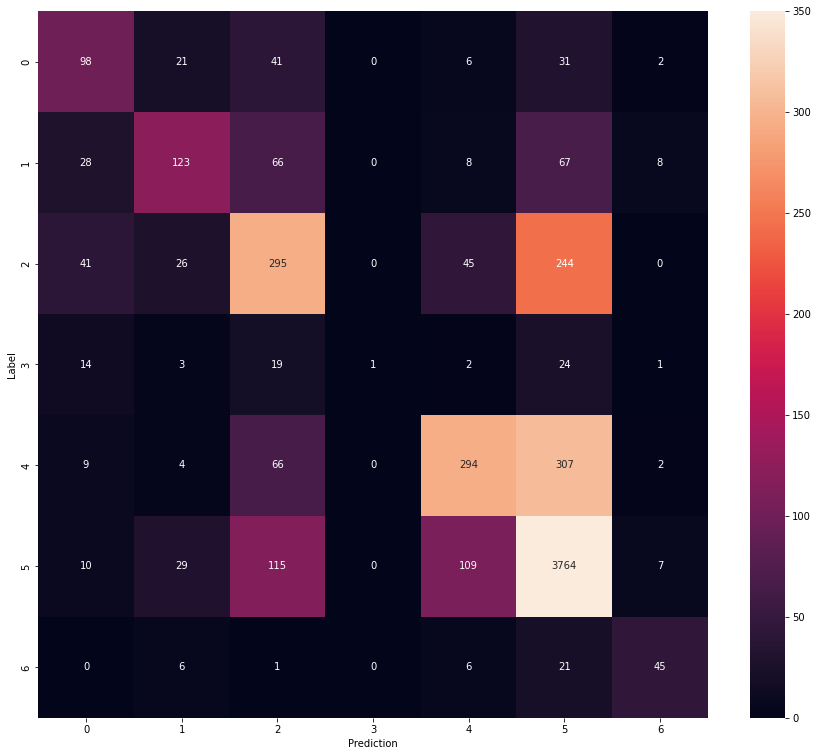

In [107]:
plt.figure(figsize=(15,13))

sns.heatmap(confusion_matrix(np.argmax(y_train,axis=1),np.argmax(preds,axis=1)),annot=True,vmin=0,vmax=350,fmt='.5g')
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()

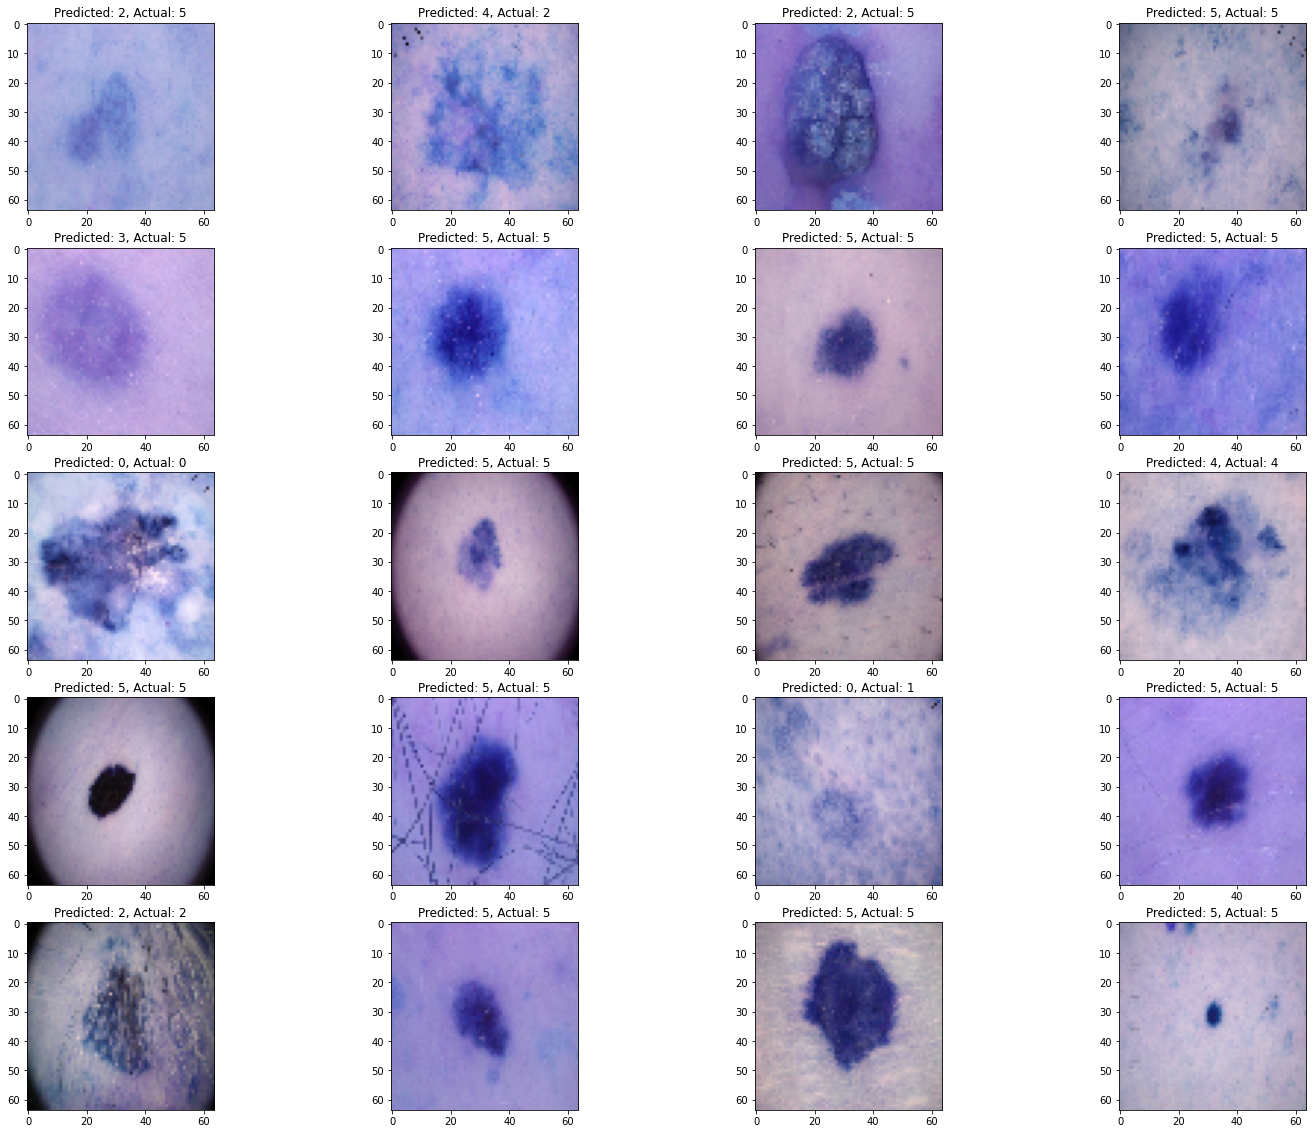

In [75]:
f = plt.figure(figsize=(25,20))
for i in range(20):
    c_x, c_y = np.array([X_val[i]]), y_val[i]
    y_pred = model.predict(c_x)
    ax = plt.subplot(5,4,i+1)
    ax.imshow(c_x[0])
    ax.set_title("Predicted: {}, Actual: {}".format(np.argmax(c_y),np.argmax(y_pred)))

plt.show()

# Input DIM=(64,64,3)



## Model 1: "sequential_8"
_________________________________________________________________
### Layer (type)                Output Shape              Param #   
=================================================================
 conv2d_85 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 conv2d_86 (Conv2D)          (None, 64, 64, 16)        2320      
                                                                 
 conv2d_87 (Conv2D)          (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_88 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 conv2d_89 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_90 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_92 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 conv2d_93 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 4096)              0         
                                                                 
 dense_16 (Dense)            (None, 64)                262208    
                                                                 
 dense_17 (Dense)            (None, 7)                 455       
                                                                 
=================================================================
Total params: 383,239
Trainable params: 383,239
Non-trainable params: 0
_________________________________________________________________

Evaluations: [Loss,Acc] [0.7688291668891907, 0.7269326448440552], [0.8108662962913513, 0.6995012760162354], [0.6965059638023376, 0.7593516111373901]

## Model 2: "sequential_21"
_________________________________________________________________
### Layer (type)                Output Shape              Param #   
=================================================================
 conv2d_226 (Conv2D)         (None, 64, 64, 16)        448       
                                                                 
 conv2d_227 (Conv2D)         (None, 64, 64, 16)        2320      
                                                                 
 conv2d_228 (Conv2D)         (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_229 (Conv2D)         (None, 32, 32, 32)        4640      
                                                                 
 conv2d_230 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 conv2d_231 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_232 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_233 (Conv2D)         (None, 16, 16, 64)        36928     
                                                                 
 conv2d_234 (Conv2D)         (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_235 (Conv2D)         (None, 8, 8, 64)          36928     
                                                                 
 conv2d_236 (Conv2D)         (None, 8, 8, 64)          36928     
                                                                 
 conv2d_237 (Conv2D)         (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 1024)              0         
                                                                 
 dense_42 (Dense)            (None, 64)                65600     
                                                                 
 dense_43 (Dense)            (None, 7)                 455       
                                                                 
=================================================================
Total params: 297,415
Trainable params: 297,415
Non-trainable params: 0
_________________________________________________________________

Evaluations: [Loss,Acc] [0.7815272212028503, 0.7069825530052185], [0.8313598036766052, 0.6957606077194214], [0.7358073592185974, 0.7306733131408691]


## Model 3: "sequential_22"
_________________________________________________________________
### Layer (type)                Output Shape              Param #   
=================================================================
 conv2d_238 (Conv2D)         (None, 64, 64, 16)        448       
                                                                 
 conv2d_239 (Conv2D)         (None, 64, 64, 16)        2320      
                                                                 
 conv2d_240 (Conv2D)         (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_241 (Conv2D)         (None, 32, 32, 32)        4640      
                                                                 
 conv2d_242 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 conv2d_243 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_244 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_245 (Conv2D)         (None, 16, 16, 64)        36928     
                                                                 
 conv2d_246 (Conv2D)         (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_247 (Conv2D)         (None, 8, 8, 64)          36928     
                                                                 
 conv2d_248 (Conv2D)         (None, 8, 8, 64)          36928     
                                                                 
 conv2d_249 (Conv2D)         (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 flatten_22 (Flatten)        (None, 1024)              0         
                                                                 
 dense_44 (Dense)            (None, 32)                32800     
                                                                 
 dense_45 (Dense)            (None, 16)                528       
                                                                 
 dense_46 (Dense)            (None, 7)                 119       
                                                                 
=================================================================
Total params: 264,807
Trainable params: 264,807
Non-trainable params: 0
_________________________________________________________________
None

Evaluations: [Loss,Acc] [0.6949036121368408, 0.7468827962875366], [0.8058047294616699, 0.694513738155365], [0.7365868091583252, 0.7244389057159424]